<a href="https://colab.research.google.com/github/zubairwazir/titanic-competition-kaggle/blob/master/Titanic_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Titanic - Machine Learning from Disaster**

Titanic Dataset from Kaggle Competition

In [1]:
import sys
import io
import pdb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb
from google.colab import files
import re

# **Loading CSV files into Colab from a local drive**

In [2]:
try:
  train_data = pd.read_csv('train.csv')  
except:
  uploaded = files.upload()
  train_data = pd.read_csv('train.csv')

try:
  test_data = pd.read_csv('test.csv')
except:
  uploaded = files.upload()
  test_data = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Saving train.csv to train.csv


Saving test.csv to test.csv


# **EDA step**

> **Total de dados:** 891 registros\
> **Total de features:** 12 features\
> **Feature alvo:** Survived

* Cada registro representa um passageiro do Titanic.

* A feature alvo (Survived) indica se um determinado passageiro sobreviveu ou não ao naufrágio. 

* Survived é utilizada na formulação do problema de ML, que visa prever se um determinado passageiro sobreviveu ou não considerando os outros 11 atributos do dataset.

**Missing values:**

* **Train dataset:** features Age, Cabin, Embarked

* **Test dataset:** features Age, Fare, Cabin

In [3]:
print(train_data.head())
print(test_data.head())

#print(train_data.shape)
#print(train_data.tail())
#print(train_data.columns)
#print(train_data.describe())
print(train_data.info())
#print(train_data.isnull().sum())

print(test_data.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

**Análise das features mais relevantes:**

> **Feature Survived:** Indica se o passageiro sobreviveu ou não ao naufrágio.

* Sem dados faltantes.
* Valores desbalanceados, onde 62% (549) das pessoas morreram e 38% (342) sobreviveram.
* Nota-se que a sobrevivência está relacionada ao número de botes e coletes salva-vidas disponíveis no navio. Fica evidente que não havia material de resgate para todos os passageiros. 
* Considera-se também alguns casos onde as pessoas não conseguiram chegar à área externa, permanecendo presas dentro do navio.

Total de valores da feature Survived:
0    549
1    342
Name: Survived, dtype: int64

Porcentagem total de valores da feature Survived:
0    0.616162
1    0.383838
Name: Survived, dtype: float64

Classes de valores únicos da feature Survived:
[0 1]



[Text(0, 0, 'Died'), Text(0, 0, 'Survived')]

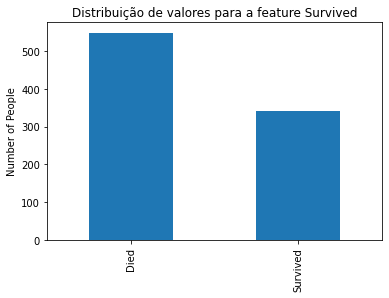

In [4]:
var='Survived' #indica se a pessoa sobreviveu ou não
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde 62% das pessoas morreram
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature

ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xticklabels(labels=['Died', 'Survived'])

> **Feature Sex:**

* Sem dados faltantes.
* Valores desbalanceados, onde 65% (577) das pessoas eram homens e 35% (314) eram mulheres.

> **Q1: Sabe-se que mulheres e crianças tenderam a serem salvas primeiro. Existe relação entre as pessoas que não sobreviveram e o sexo masculino?**

Total de valores da feature Sex:
male      577
female    314
Name: Sex, dtype: int64

Porcentagem total de valores da feature Sex:
male      0.647587
female    0.352413
Name: Sex, dtype: float64

Classes de valores únicos da feature Sex:
['male' 'female']



Text(0, 0.5, 'Number of People')

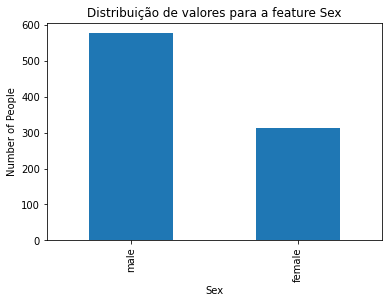

In [5]:
var='Sex'
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde 65% das pessoas eram homens
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_xlabel('Sex')
ax.set_ylabel('Number of People')

> **Feature Age:**

> Distribuição dos valores:\
**count:**     714\
**missing:**   177\
**mean:**      29.7 anos\
**std:**       14.5 anos\
**min:**      0.4 anos\
**25%:**       20.1 anos\
**50%:**       28 anos\
**75%:**      38 anos\
**max:**       80 anos

* **Dados faltantes (177).**
* Valores desbalanceados, variando entre 0.4 e 80 anos.
* 50% das pessoas apresentam menos de 28 anos.
* 75% das pessoas apresentam menos de 38 anos.
* Maior concentração de pessoas com idades entre 18 e 40 anos.

> * Porcentagem de pessoas com menos de 15 anos (crianças?):  8.75% (78)
* Porcentagem de pessoas com menos de 18 anos:  12.68% (113)
* Porcentagem de pessoas do sexo masculino com menos de 18 anos:  6.51% (58)
* Porcentagem de pessoas do sexo feminino com menos de 18 anos:  6.17% (55)
* Porcentagem de pessoas entre 18 e 40 anos:  50.62% (451)
* Porcentagem de pessoas entre 41 e 65 anos:  15.71% (140)
* Porcentagem de pessoas com mais de 65 anos:  0.9% (8)

Total de valores da feature Age:
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

Classes de valores únicos da feature Age:
[22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 

Porcentagem de pessoas com menos de 15

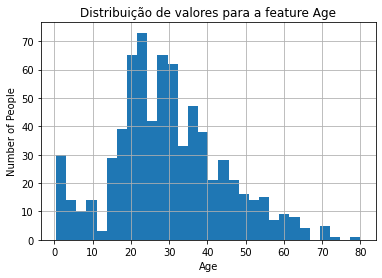

In [6]:
var='Age'
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
#print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, maior concentração de pessoas com idades entre 20 e 40 anos
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
print(train_data[var].describe(), '\n')
ax=train_data[var].hist(bins=30)
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Age')

print('Porcentagem de pessoas com menos de 15 anos (crianças?): ', len(train_data[train_data['Age']<15])/len(train_data)*100, len(train_data[train_data['Age']<15]))
print('Porcentagem de pessoas com menos de 18 anos: ', len(train_data[train_data['Age']<18])/len(train_data)*100, len(train_data[train_data['Age']<18]))
print('Porcentagem de pessoas do sexo masculino com menos de 18 anos: ', len(train_data[(train_data['Age']<18) & (train_data['Sex']=='male')])/len(train_data)*100, len(train_data[(train_data['Age']<18) & (train_data['Sex']=='male')]))
print('Porcentagem de pessoas do sexo feminino com menos de 18 anos: ', len(train_data[(train_data['Age']<18) & (train_data['Sex']=='female')])/len(train_data)*100, len(train_data[(train_data['Age']<18) & (train_data['Sex']=='female')]))
print('Porcentagem de pessoas entre 18 e 40 anos: ', len(train_data[(train_data['Age']>=18) & (train_data['Age']<=40)])/len(train_data)*100, len(train_data[(train_data['Age']>=18) & (train_data['Age']<=40)]))
print('Porcentagem de pessoas entre 41 e 65 anos: ', len(train_data[(train_data['Age']>=41) & (train_data['Age']<=65)])/len(train_data)*100, len(train_data[(train_data['Age']>=41) & (train_data['Age']<=65)]))
print('Porcentagem de pessoas com mais de 65 anos: ', len(train_data[(train_data['Age']>=66)])/len(train_data)*100, len(train_data[(train_data['Age']>=66)]))

> **Feature Pclass:** Indica a classe ocupada no navio, sendo elas: classe 1 (primeira classe), classe 2 (intermediária) e classe 3 (mais econômica).

* Sem dados faltantes.
* Valores desbalanceados, onde 55% (491) das pessoas ocupam a classe 3ª classe (mais econômica), 21% (184) ocupam a 2ª classe (intermediária) e 24% (216) estão na primeira classe (mais cara).

> **Q2: Considerando os homens que sobreviveram, existe alguma relação com a classe ocupada? E as mulheres que não sobreviveram, pertenciam a alguma classe específica?**

Total de valores da feature Pclass:
3    491
1    216
2    184
Name: Pclass, dtype: int64

Porcentagem total de valores da feature Pclass:
3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

Classes de valores únicos da feature Pclass:
[3 1 2]



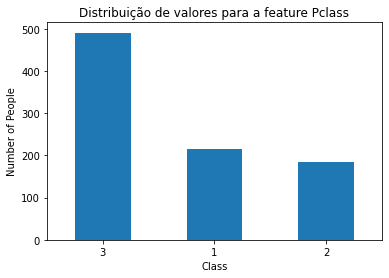

In [7]:
var='Pclass' #indica a classe no navio (1, 2 e 3)
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde 55% das pessoas ocuparam a classe 3 (mais barata), 25% a classe 2 (intermediária) e 20% a primeira classe (mais ricos)
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Class')
ax.tick_params(axis='x', labelrotation=0)

> **Feature Fare:** Indica o valor da passagem utilizada pelo passageiro.

> Distribuição dos valores:\
**count:**    891\
**missing:**  0\
**mean:**     32.2\
**std:**      49.7\
**min:**      0\
**25%:**      7.9\
**50%:**      14.5\
**75%:**      31\
**max:**      512.3

* Valores desbalanceados, variando entre 0 e 512:
* 75% das pessoas pagaram valores inferiores a 31.
* Maior parte das pessoas pagaram valores de passagem entre 0 e 50.

* Porcentagem de pessoas que pagaram até 50:  81.9%\
* Porcentagem de pessoas que pagaram até 100:  94.1%

> **Discriminação dos valores de passagens para pessoas da classe 3 (classe mais econômica):**\
count:     491\
mean:      13.675550\
std:       11.778142\
min:        0.000000\
25%:        7.750000\
50%:        8.050000\
75%:       15.500000\
max:       69.550000

> **Discriminação dos valores de passagens para pessoas da classe 2:**\
count:     184\
mean:     20.662183\
std:       13.417399\
min:       0.000000\
25%:       13.000000\
50%:       14.250000\
75%:       26.000000\
max:       73.500000

> **Discriminação dos valores de passagens para pessoas da classe 1 (classe mais cara):**\
count:     216\
mean:      84.154687\
std:      78.380373\
min:       0.000000\
25%:       30.923950\
50%:       60.287500\
75%:       93.500000\
max:       512.329200

> **Q3: O preço da passagem está relacionado com a classe ocupada?**

Total de valores da feature Fare:
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

Porcentagem total de valores da feature Fare:
8.0500     0.048260
13.0000    0.047138
7.8958     0.042649
7.7500     0.038159
26.0000    0.034792
             ...   
35.0000    0.001122
28.5000    0.001122
6.2375     0.001122
14.0000    0.001122
10.5167    0.001122
Name: Fare, Length: 248, dtype: float64

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64 

Porcentagem de pessoas que pagaram até 50:  81.9304152637486
Porcentagem de pessoas que pagaram até 100:  94.05162738496072


Valores de passagens para classe 3:
 count    491.000000
mean      13.675550
std       11.778142
min        0.000000
25%        7.750000
50%        8.0

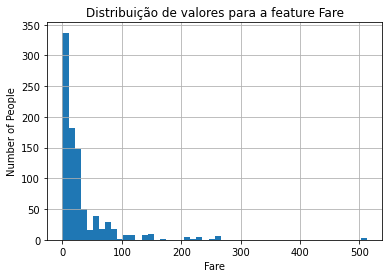

In [8]:
var='Fare' #indica o valor da passagem
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde a maior parte das pessoas pagaram entre 0 e 100. Feature variando entre 0 e 512.
#print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
print(train_data[var].describe(), '\n')

ax=train_data[var].hist(bins=50)
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Fare')

print('Porcentagem de pessoas que pagaram até 50: ', len(train_data[train_data['Fare']<50])/len(train_data)*100)
print('Porcentagem de pessoas que pagaram até 100: ', len(train_data[train_data['Fare']<100])/len(train_data)*100)
print('\n')

print('Valores de passagens para classe 3:\n', train_data['Fare'][train_data['Pclass']==3].describe(), '\n')
print('Valores de passagens para classe 2:\n',train_data['Fare'][train_data['Pclass']==2].describe(), '\n')
print('Valores de passagens para classe 1:\n',train_data['Fare'][train_data['Pclass']==1].describe(), '\n')

> **Feature Parch:** Indica com quantos acompanhantes a pessoa estava viajando, sendo eles pais ou filhos.

* Sem dados faltantes.
* Valores desbalanceados, onde 76% (678) das pessoas estavam viajando sem os pais ou filhos;
* 13% (118) estavam viajando com apenas um desses acompanhantes;
* 9% (80) viajavam com dois desses acompanhantes.

Total de valores da feature Parch:
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Porcentagem total de valores da feature Parch:
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64

Classes de valores únicos da feature Parch:
[0 1 2 5 3 4 6]



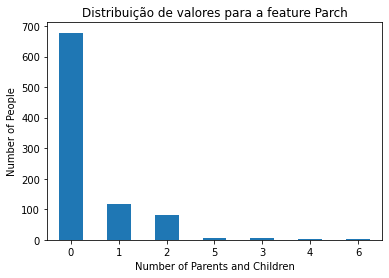

In [9]:
var='Parch' #indica com quantos acompanhantes a pessoa estava viajando, sendo eles pais ou filhos
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde 76% das pessoas estavam viajando sem os pais ou filhos
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Number of Parents and Children')
ax.tick_params(axis='x', labelrotation=0)

> **Feature SibSp:** Indica com quantos acompanhantes a pessoa estava viajando, sendo eles irmãos ou cônjuge.

* Sem dados faltantes.
* Valores desbalanceados, onde 78% (608) das pessoas estavam viajando sem irmãos ou cônjuge; 
* 23% (209) estavam viajando com apenas um desses acompanhantes.

Total de valores da feature SibSp:
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Porcentagem total de valores da feature SibSp:
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64

Classes de valores únicos da feature SibSp:
[1 0 3 4 2 5 8]



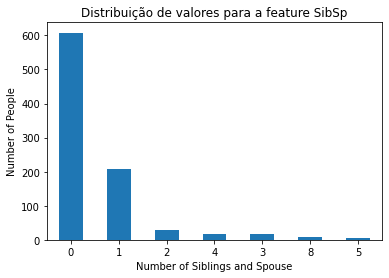

In [10]:
var='SibSp' #indica com quantos acompanhantes a pessoa estava viajando, sendo eles irmãos ou cônjuge
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde 78% das pessoas estavam viajando sem irmãos ou cônjuge
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Number of Siblings and Spouse')
ax.tick_params(axis='x', labelrotation=0)

> **Feature Parch e SibSp: Soma das duas features para representar o total de acompanhantes de um passageiro, sendo eles pais, filhos, irmãos ou cônjuge.**

* Valores desbalanceados, onde 60% (537) das pessoas estavam viajando sozinhas;
* 18% (161) estavam viajando com apenas um acompanhante.
* 11% (102) estavam viajando com dois acompanhantes.

* Total de pessoas com um ou mais acompanhantes: 354 (40%) pessoas.
* Total de pessoas com mais de um acompanhante, sendo pelo menos um pai ou filho e um irmão ou cônjuge:  142 (16%) pessoas.

* **Q4: Desconsiderando mulheres e crianças, homens com acompanhantes tenderam a sobreviver mais? Ou ainda, homens ricos e acompanhados tiveram mais chances?**

Total de valores da feature Parch_SibSp:
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Parch_SibSp, dtype: int64

Porcentagem total de valores da feature Parch_SibSp:
0     0.602694
1     0.180696
2     0.114478
3     0.032548
5     0.024691
4     0.016835
6     0.013468
10    0.007856
7     0.006734
Name: Parch_SibSp, dtype: float64

Classes de valores únicos da feature Parch_SibSp:
[ 1  0  4  2  6  5  3  7 10]

Total de pessoas com um ou mais acompanhantes:  354
Total de pessoas com mais de um acompanhante, sendo pai ou filho e irmão ou cônjuge:  142 15.937149270482603


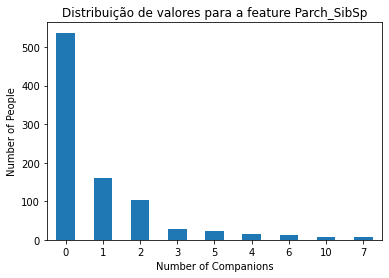

In [11]:
train_data['Parch_SibSp']=train_data['Parch']+train_data['SibSp']
train_data['Parch_SibSp'].describe()

var='Parch_SibSp' #indica com quantos acompanhantes a pessoa estava viajando
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde 60% das pessoas estavam viajando sozinhas
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature

ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Number of Companions')
ax.tick_params(axis='x', labelrotation=0)

print('Total de pessoas com um ou mais acompanhantes: ', len(train_data[(train_data['Parch_SibSp']>0)]))
print('Total de pessoas com mais de um acompanhante, sendo pai ou filho e irmão ou cônjuge: ', len(train_data[(train_data['Parch']>0) & (train_data['SibSp']>0)]), len(train_data[(train_data['Parch']>0) & (train_data['SibSp']>0)])/len(train_data)*100)

> **Feature Embarked:** Indica a estação de embarque do passageiro.

* **Dados faltantes (2).**
* Valores desbalanceados, onde 72% (644) pessoas embarcaram no porto S;
* 19% (168) embarcaram em C;
* 9% (77) embarcaram em Q.

Total de valores da feature Embarked:
S    644
C    168
Q     77
Name: Embarked, dtype: int64

Porcentagem total de valores da feature Embarked:
S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

Classes de valores únicos da feature Embarked:
['S' 'C' 'Q' nan]



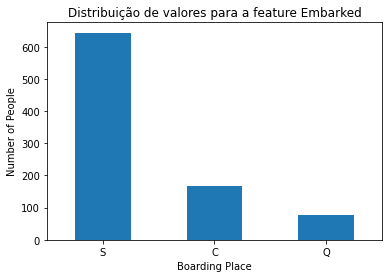

In [12]:
var='Embarked' #indica com quantos acompanhantes a pessoa estava viajando, sendo eles irmãos ou cônjuge
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados, onde 78% das pessoas estavam viajando sem irmãos ou cônjuge
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Boarding Place')
ax.tick_params(axis='x', labelrotation=0)

# **Relation between features**


In [13]:
#groupby
display(train_data.groupby(['Sex', 'Survived', 'Pclass']).mean())

PassengerId        Age     SibSp     Parch  \
Sex    Survived Pclass                                               
female 0        1        325.000000  25.666667  0.666667  1.333333   
                2        423.500000  36.000000  0.500000  0.166667   
                3        440.375000  23.818182  1.291667  1.097222   
       1        1        473.967033  34.939024  0.549451  0.428571   
                2        444.785714  28.080882  0.485714  0.642857   
                3        359.083333  19.329787  0.500000  0.500000   
male   0        1        413.623377  44.581967  0.272727  0.259740   
                2        454.010989  33.369048  0.307692  0.142857   
                3        456.750000  27.255814  0.523333  0.213333   
       1        1        527.777778  36.248000  0.377778  0.311111   
                2        415.588235  16.022000  0.529412  0.647059   
                3        447.638298  22.274211  0.340426  0.297872   

                              Fare  Parch_SibSp  
Sex    Survived Pclass                           
female 0        1       110.604167     2.000000  
                2        18.250000     0.666667  
                3        19.773093     2.388889  
       1        1       105.978159     0.978022  
                2        22.288989     1.128571  
                3        12.464526     1.000000  
male   0        1        62.894910     0.532468  
                2        19.488965     0.450549  
                3        12.204469     0.736667  
       1        1        74.637320     0.688889  
                2        21.095100     1.176471  
                3        15.579696     0.638298

> **Relação entre as features Age e Sex:**

* **Através dos gráficos, percebe-se uma similaridade entre a distribuição das idades de homens e mulheres.**

* No entanto, no navio haviam mais homens do que mulheres, conforme análise prévia: 65% (577) das pessoas eram homens e 35% (314) eram mulheres.

* **Assim, a sobrevivência de mais mulheres não está relacionada com a idade das pessoas e sim com a prioridade dada ao sexo feminino.**


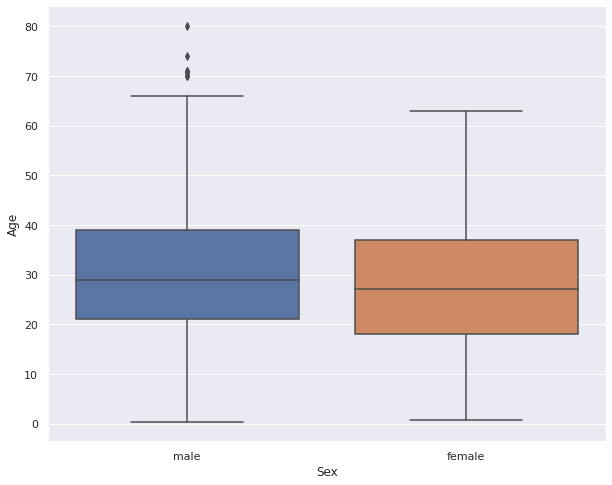

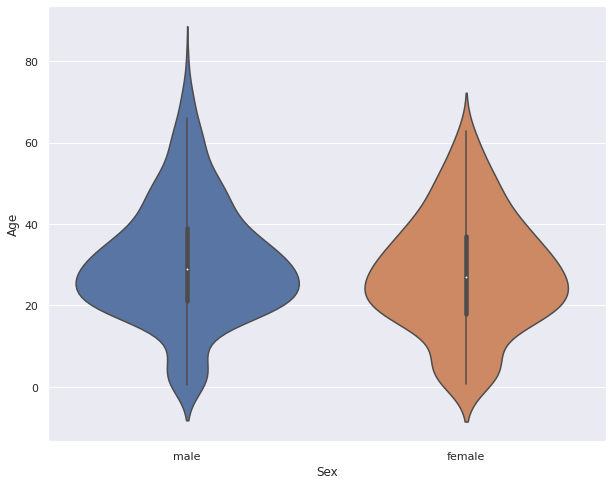

In [14]:
sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y='Age', x='Sex', data=train_data)
plt.show()

plt.figure(figsize=(10, 8))
sns.violinplot(y='Age', x='Sex', data=train_data)
plt.show()

> **Relação entre as features Age e Survived:**

* **Percebe-se uma similaridade entre a distribuição das idades das pessoas que sobreviveram e que morreram.**

* No entanto, mais pessoas morreram (62% - 549) do que sobreviveram (38% - 342).

* **Assim, notamos que apesar da prioridade dada as crianças, algumas também morreram.**

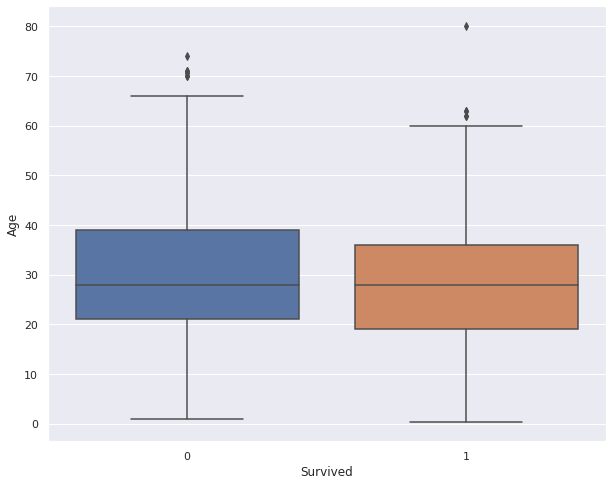

In [15]:
sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y='Age', x='Survived', data=train_data)

> **Relação entre as features Sex e Survived:**

* **Considerando que haviam no navio mais homens do que mulheres, proporcionalmente a cada categoria, percebe-se que mais mulheres sobreviveram em relação aos homens.**

> **Resposta Q1: Sabe-se que mulheres e crianças tenderam a serem salvas primeiro. Existe relação entre as pessoas que não sobreviveram e o sexo masculino? Sim, mais homens morreram em comparação com as mulheres.**

In [16]:
display(pd.crosstab([train_data['Sex']], train_data['Survived']))

display(pd.crosstab([train_data['Sex']], train_data['Survived'], normalize='index'))

Survived,0,1
Sex,,
female,81,233
male,468,109


Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


Text(0, 0.5, 'Number of People')

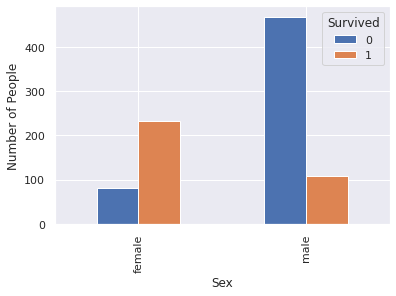

In [17]:
pd.crosstab([train_data['Sex']], train_data['Survived']).plot.bar()
plt.ylabel('Number of People')

> **Relação entre as features Sex, Survived e Pclass:**

* Considerando que mais homens morreram, e haviam mais homens na classe 3, proporcionalmente a cada categoria de Pclass, percebe-se que os homens da primeira classe tiveram prioridade no salvamento.

* Os homens da primeira classe, mesmo em menos número, foram os que mais sobreviveram.

> **Resposta Q2: Considerando os homens que sobreviveram, existe alguma relação com a classe ocupada? Proporcionalmente ao total de homens em cada categoria de Pclass, os homens da primeira classe sobreviveram em maior número.**

> **Resposta Q2: E as mulheres que não sobreviveram, pertenciam a alguma classe específica? Assim como no caso anterior, proporcionalmente ao total de mulheres em cada categoria de Pclass, mulheres da primeira classe sobreviveram em maior número. Poucas mulheres da primeira e segunda classe morreram, as mulheres que morreram em geral pertenciam a classe 3.**

Survived         0   1
Sex    Pclass         
female 1         3  91
       2         6  70
       3        72  72
male   1        77  45
       2        91  17
       3       300  47

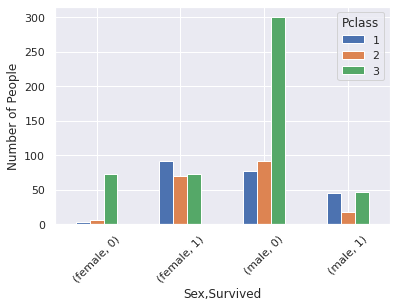

In [18]:
#display(pd.crosstab([train_data['Sex'], train_data['Pclass']], train_data['Survived'], values=train_data['Age'], aggfunc='mean'))

display(pd.crosstab([train_data['Sex'], train_data['Pclass']], train_data['Survived']))

pd.crosstab([train_data['Sex'], train_data['Survived']], train_data['Pclass']).plot.bar()
plt.ylabel('Number of People')
plt.tick_params(axis='x', labelrotation=45)
plt.show()

> **Relação entre as features Pclass e Fare:**

> **Resposta Q3: O preço da passagem está relacionado com a classe ocupada? Sim, a primeira classe engloba passagens mais caras. Os outliers de cada classe podem ser explicados talvez pela data da compra (passagens compradas no dia tendem a ser mais caras, por exemplo).**

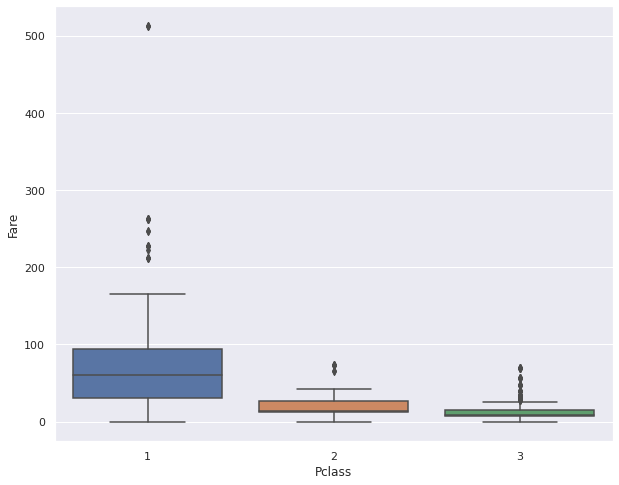

In [19]:
sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y='Fare', x='Pclass', data=train_data)

> **Relação entre as features Parch, SibSp, Parch_SibSp e Survived em relação aos homens:**

* Comparando homens acompanhados e sem nenhum acompanhante, nota-se que homens não acompanhados sobreviveram mais em números absolutos.

* Contudo, haviam mais homens não acompanhados do que acompanhados no navio. 

* Assim, homens não acompanhados morreram mais também. 

> **Resposta Q4: Desconsiderando mulheres e crianças, homens com acompanhantes tenderam a sobreviver mais? Não, homens não acompanhados sobreviveram em maior número.**

**> Resposta Q4: Ou ainda, homens ricos e acompanhados tiveram mais chances? Não, mesmo para homens ricos o padrão se manteve, homens não acompanhados sobreviveram mais.**

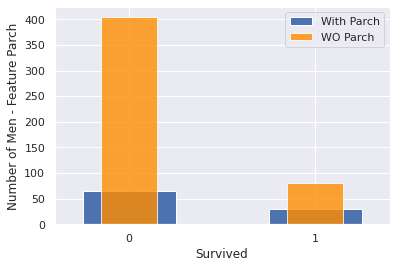

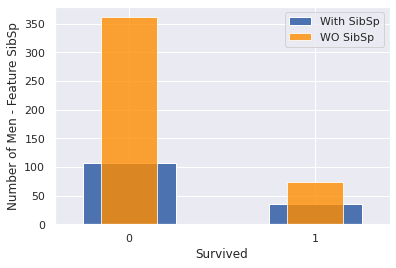

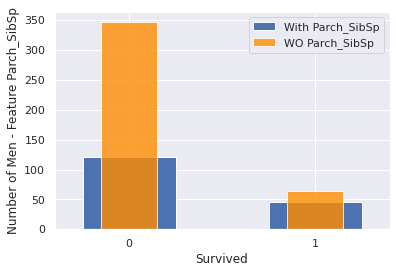

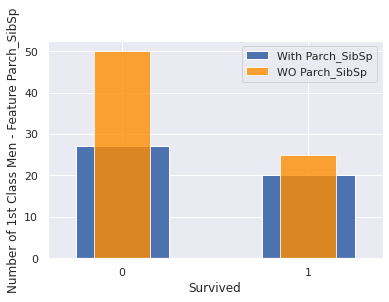

In [20]:
##Homens acompanhados de um ou mais pais ou filhos versus sobrevivência
train_data[(train_data['Sex']=='male') & (train_data['Parch']>0)]['Survived'].value_counts(normalize=False).plot.bar(label='With Parch')
train_data[(train_data['Sex']=='male') & (train_data['Parch']==0)]['Survived'].value_counts(normalize=False).plot.bar(alpha=0.8, color='darkorange', width=0.3, label='WO Parch')
plt.xlabel('Survived')
plt.ylabel('Number of Men - Feature Parch')
plt.legend()
plt.tick_params(axis='x', labelrotation=0)
plt.show()

##Homens acompanhados de um ou mais irmãos ou conjuge versus sobrevivência
train_data[(train_data['Sex']=='male') & (train_data['SibSp']>0)]['Survived'].value_counts(normalize=False).plot.bar(label='With SibSp')
train_data[(train_data['Sex']=='male') & (train_data['SibSp']==0)]['Survived'].value_counts(normalize=False).plot.bar(alpha=0.8, color='darkorange', width=0.3, label='WO SibSp')
plt.xlabel('Survived')
plt.ylabel('Number of Men - Feature SibSp')
plt.legend()
plt.tick_params(axis='x', labelrotation=0)
plt.show()

##Homens acompanhados de um ou mais pais, filhos, irmãos ou conjuge versus sobrevivência
train_data[(train_data['Sex']=='male') & (train_data['Parch_SibSp']>0)]['Survived'].value_counts(normalize=False).plot.bar(label='With Parch_SibSp')
train_data[(train_data['Sex']=='male') & (train_data['Parch_SibSp']==0)]['Survived'].value_counts(normalize=False).plot.bar(alpha=0.8, color='darkorange', width=0.3, label='WO Parch_SibSp')
plt.xlabel('Survived')
plt.ylabel('Number of Men - Feature Parch_SibSp')
plt.legend()
plt.tick_params(axis='x', labelrotation=0)
plt.show()

##Homens da primeira classe acompanhados de um ou mais pais, filhos, irmãos ou conjuge versus sobrevivência
train_data[(train_data['Sex']=='male') & (train_data['Pclass']==1) & (train_data['Parch_SibSp']>0)]['Survived'].value_counts(normalize=False).plot.bar(label='With Parch_SibSp')
train_data[(train_data['Sex']=='male') & (train_data['Pclass']==1) & (train_data['Parch_SibSp']==0)]['Survived'].value_counts(normalize=False).plot.bar(alpha=0.8, color='darkorange', width=0.3, label='WO Parch_SibSp')
plt.xlabel('Survived')
plt.ylabel('Number of 1st Class Men - Feature Parch_SibSp')
plt.legend()
plt.tick_params(axis='x', labelrotation=0)
plt.show()

# **Correlation between features**

> Determinação do grau de relacionamento entre duas features. Caso os pontos das variáveis, representados num plano cartesiano (x, y) ou gráfico de dispersão, apresentem uma dispersão similar ao longo de uma reta imaginária, diz-se que os dados apresentam correlação linear que pode ser negativa (próxima à -1) ou positiva (próxima à 1). Caso não apresentem, o cálculo de correlação será igual à 0.

> **Porém, correlação não implica em causalidade.**

O fato de variáveis estarem correlacionados não quer dizer que uma *influência* no comportamento da outra. O padrão de comportamento pode estar associado a fatores externos sem relação entre si.

> **Aparentemente só há um cenário de correlação: Consiste na correlação entre as features Parch e Parch_SibSp, e Parch_SibSp e SibSp.**

* Isso se deve o fato de Parch_SibSp ser a soma dessas duas features.

* Parch e SibSp apresentam correlação baixa.

* Assim, seria possível considerar somente Parch_SibSp ou desconsiderá-la para considerar Parch e SibSp.

,Survived,Pclass,Age,SibSp,Parch,Fare,Parch_SibSp
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.016639
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.065997
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.301914
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.890712
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.783111
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.217138
Parch_SibSp,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,1.000000


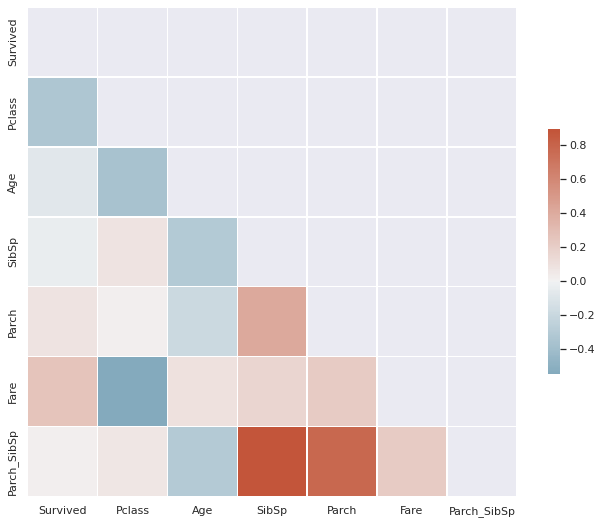

In [21]:
corr=train_data.iloc[:, 1:].corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **Feature transformation**

Transformation of nominal features to numerical features.

Operations applied to both train and test datasets.


* Feature Sex (str) para Sex_bin (binária)

* Feature Embarked (str) para Embarked_num (numérica)

* Feature Cabin_null representando valores ausentes de Cabin. 


In [22]:
##Transformation of nominal features to numerical features
def sex_to_bin(val):
    if val=='female':
        return 1
    else:
        return 0

def embarked_to_num(val):
    if val=='S':
        return 0
    elif val=='C':
        return 1
    elif val=='Q':
        return 2

train_data['Sex_bin']=train_data['Sex'].map(sex_to_bin)
test_data['Sex_bin']=test_data['Sex'].map(sex_to_bin)

train_data['Embarked_num']=train_data['Embarked'].map(embarked_to_num)
test_data['Embarked_num']=test_data['Embarked'].map(embarked_to_num)

#Booleans
train_data['Cabin_null']=train_data['Cabin'].isnull().astype(int) 
test_data['Cabin_null']=test_data['Cabin'].isnull().astype(int)

#train_data['Embarked_S']=(train_data['Embarked']=='S').astype(int) 
#test_data['Embarked_S']=(test_data['Embarked']=='S').astype(int)

#train_data['Embarked_C']=(train_data['Embarked']=='C').astype(int) 
#test_data['Embarked_C']=(test_data['Embarked']=='C').astype(int) 

* Títulos existentes na feature Name utilizados como features individuais indicando possível importância de um certo passageiro.

* Títulos mais frequentes usados: (' Mr. ', 517), (' Miss. ', 182), (' Mrs. ', 125), (' Master. ', 40), (' Dr. ', 7), (' Rev. ', 6)


In [23]:
##titles of names
names=train_data['Name'].unique()
name_re = re.compile('\w+\.')
#name_pref=list(set(name_re.findall(str(names)))) #remove duplicated strings
name_pref=[name_re.findall(str(n)) for n in names]
dict_name_pref={}
for n in name_pref:
  if n[0] in dict_name_pref:
    dict_name_pref[n[0]]+=1
  else:
    dict_name_pref[n[0]]=1
name_pref=sorted(dict_name_pref.items(), key=lambda x: x[1], reverse=True)
prefs=[]
for n in name_pref:
  if n[1]>1:
    prefs.append(n)
print(prefs)
##[(' Mr. ', 517), (' Miss. ', 182), (' Mrs. ', 125), (' Master. ', 40), (' Dr. ', 7), (' Rev. ', 6), (' Major. ', 2), (' Mlle. ', 2), (' Col. ', 2)]

train_data['Name_have_Miss']=train_data['Name'].str.contains(' Miss. ').astype(int)
train_data['Name_have_Mrs']=train_data['Name'].str.contains(' Mrs. ').astype(int)

train_data['Name_have_Mr']=train_data['Name'].str.contains(' Mr. ').astype(int)
train_data['Name_have_Master']=train_data['Name'].str.contains(' Master. ').astype(int)
train_data['Name_have_Dr']=train_data['Name'].str.contains(' Dr. ').astype(int)
train_data['Name_have_Rev']=train_data['Name'].str.contains(' Rev. ').astype(int)

test_data['Name_have_Miss']=test_data['Name'].str.contains(' Miss. ').astype(int)
test_data['Name_have_Mrs']=test_data['Name'].str.contains(' Mrs. ').astype(int)

test_data['Name_have_Mr']=test_data['Name'].str.contains(' Mr. ').astype(int)
test_data['Name_have_Master']=test_data['Name'].str.contains(' Master. ').astype(int)
test_data['Name_have_Dr']=test_data['Name'].str.contains(' Dr. ').astype(int)
test_data['Name_have_Rev']=test_data['Name'].str.contains(' Rev. ').astype(int)

[('Mr.', 517), ('Miss.', 182), ('Mrs.', 125), ('Master.', 40), ('Dr.', 7), ('Rev.', 6), ('Major.', 2), ('Mlle.', 2), ('Col.', 2)]


# **Correlation between features II**


,Survived,Pclass,Age,SibSp,Parch,Fare,Parch_SibSp,Sex_bin,Embarked_num,Cabin_null,Name_have_Miss,Name_have_Mrs,Name_have_Mr,Name_have_Master,Name_have_Dr,Name_have_Rev
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.016639,0.543351,0.108669,-0.316912,0.327093,0.339040,-0.549199,0.085221,0.008185,-0.064988
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.065997,-0.131900,0.043835,0.725541,-0.000576,-0.149209,0.142698,0.082081,-0.108935,-0.030413
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.301914,-0.093254,0.012186,-0.249732,-0.276792,0.180278,0.206341,-0.398827,0.078008,0.085407
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.890712,0.114631,-0.060606,0.040460,0.087932,0.063407,-0.250489,0.349559,0.003910,-0.026622
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.783111,0.245489,-0.079320,-0.036987,0.105567,0.225852,-0.333905,0.267344,-0.042150,-0.021967
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.217138,0.182333,0.063462,-0.482075,0.118271,0.105203,-0.183766,0.010908,0.030395,-0.023031
Parch_SibSp,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,1.000000,0.200988,-0.081057,0.009175,0.112838,0.156168,-0.338014,0.372472,-0.018386,-0.029170
Sex_bin,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,0.200988,1.000000,0.118593,-0.140391,0.686808,0.547600,-0.867334,-0.159934,-0.039034,-0.060741
Embarked_num,0.108669,0.043835,0.012186,-0.060606,-0.079320,0.063462,-0.081057,0.118593,1.000000,-0.016190,0.168895,-0.040411,-0.115698,-0.012701,0.029316,-0.003743
Cabin_null,-0.316912,0.725541,-0.249732,0.040460,-0.036987,-0.482075,0.009175,-0.140391,-0.016190,1.000000,-0.035314,-0.118300,0.137319,0.027841,-0.042277,0.044868


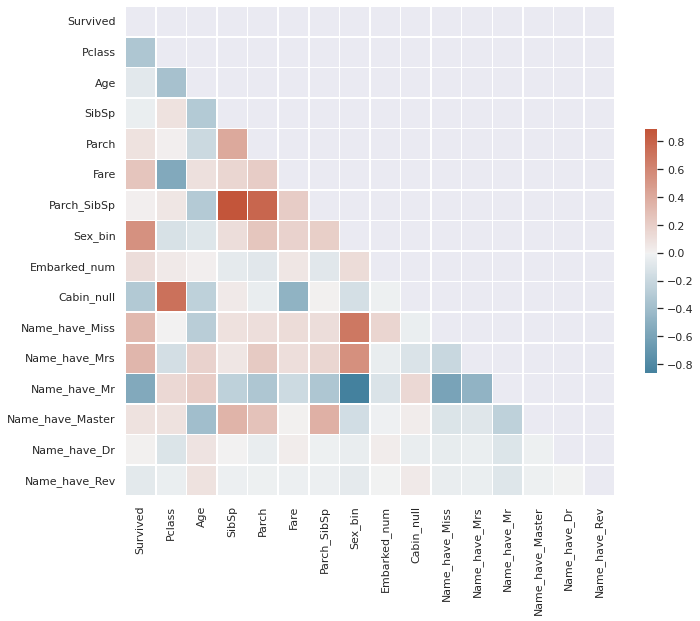

In [24]:
corr=train_data.iloc[:, 1:].corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **ML steps**

Problema a ser resolvido: Considerando as features do dataset, predizer um dado passageiro sobreviveu (1) ou não (0) de acordo com a feature-alvo Survived.

**Processo de ajuste do modelo de ML:**

1. Divisão da base em treino e validação (split).

2. Ajuste dos dados de treino (fit).

3. Predição e cálculo da acurácia para o conjunto de validação (score).

4. Predição no conjunto real de teste (prediction).

**Features para o modelo de ML:**

X = Features de treino\
y = Feature-alvo

In [25]:
print(train_data.columns)

features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_bin', 'Embarked_num', 'Cabin_null', 'Name_have_Miss', 'Name_have_Mrs', 'Name_have_Mr', 'Name_have_Master', 'Name_have_Dr', 
             'Name_have_Rev']

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Parch_SibSp',
       'Sex_bin', 'Embarked_num', 'Cabin_null', 'Name_have_Miss',
       'Name_have_Mrs', 'Name_have_Mr', 'Name_have_Master', 'Name_have_Dr',
       'Name_have_Rev'],
      dtype='object')


**Train Definition**


In [26]:
X = train_data[features]
y = train_data['Survived']
display(X.head())
display(y.head())

,Pclass,Age,SibSp,Parch,Fare,Sex_bin,Embarked_num,Cabin_null,Name_have_Miss,Name_have_Mrs,Name_have_Mr,Name_have_Master,Name_have_Dr,Name_have_Rev
0,3,22.0,1,0,7.2500,0,0.0,1,0,0,1,0,0,0
1,1,38.0,1,0,71.2833,1,1.0,0,0,1,0,0,0,0
2,3,26.0,0,0,7.9250,1,0.0,1,1,0,0,0,0,0
3,1,35.0,1,0,53.1000,1,0.0,0,0,1,0,0,0,0
4,3,35.0,0,0,8.0500,0,0.0,1,0,0,1,0,0,0


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

**Test Definition**

In [27]:
X_test=test_data[features]
display(X_test.head())

,Pclass,Age,SibSp,Parch,Fare,Sex_bin,Embarked_num,Cabin_null,Name_have_Miss,Name_have_Mrs,Name_have_Mr,Name_have_Master,Name_have_Dr,Name_have_Rev
0,3,34.5,0,0,7.8292,0,2,1,0,0,1,0,0,0
1,3,47.0,1,0,7.0000,1,0,1,0,1,0,0,0,0
2,2,62.0,0,0,9.6875,0,2,1,0,0,1,0,0,0
3,3,27.0,0,0,8.6625,0,0,1,0,0,1,0,0,0
4,3,22.0,1,1,12.2875,1,0,1,0,1,0,0,0,0


**Treat Data Missing**

In [28]:
#train
meds=X['Age'].median()
X['Age']=X['Age'].fillna(meds)
X['Embarked_num']=X['Embarked_num'].fillna(X['Embarked_num'].value_counts().index[0])

#test
X_test['Age']=X_test['Age'].fillna(meds)
X_test['Embarked_num']=X_test['Embarked_num'].fillna(X['Embarked_num'].value_counts().index[0])
X_test['Fare']=X_test['Fare'].fillna(-1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

# **Data split between train and validation datasets**

Para o train_test_split define-se:
(x_treino, x_teste, y_treino, y_teste)

Funçã de divisão:
train_test_split(X, y, test_size = 0.5)

Onde,

X -> vetor features

y -> variável resposta Survived

> teste_size = 0.5 -> tamanho para a base de teste (validação). A proporção entre treino e teste varia de acordo com o volume de dados disponível. Mas, usualmente, encontra-se proporções 50/50, 30/70, 25/75 ou 20/80. 

> Aqui, será testado com 0.5 ou 50%, o que significa que a base de treino será composta pelos 50% restantes.

In [29]:
#np.random.seed(0)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.5, stratify=y, random_state=376) #test_size=0.3, 0.2
print(train_X.head())

     Pclass   Age  SibSp  Parch     Fare  Sex_bin  Embarked_num  Cabin_null  \
188       3  40.0      1      1  15.5000        0           2.0           1   
721       3  17.0      1      0   7.0542        0           0.0           1   
420       3  28.0      0      0   7.8958        0           1.0           1   
767       3  30.5      0      0   7.7500        1           2.0           1   
723       2  50.0      0      0  13.0000        0           0.0           1   

     Name_have_Miss  Name_have_Mrs  Name_have_Mr  Name_have_Master  \
188               0              0             1                 0   
721               0              0             1                 0   
420               0              0             1                 0   
767               1              0             0                 0   
723               0              0             1                 0   

     Name_have_Dr  Name_have_Rev  
188             0              0  
721             0              0  

# **ML model**

*Datasets:*

Train: train_X, train_y

Validation: val_X, val_y

Test: X_test

# **DummyClassifier algorithm: First Baseline**

O algoritmo base DummyClassifier necessita da definição da estratégia utilizada para ajustar o modelo.

DummyClassifier('most_frequent')

> Será empregada a estratégia de *dados mais frequentes*: dado o valor mais frequente da variável resposta (Survived), o modelo Dummy vai inferir que todos os registros da base de dados assumem aquele valor na feature target Survived. 

> Predição: função *predict()*. Recebe como parâmetro a base de validação val_X.

> Cálculo da acurácia: *accuracy_score function*. Recebe como parâmetros a base teste da variável resposta (val_y) e as previsões do modelo.

previsao_dummy = modelo_dummy.predict(x_teste)
accuracy_score(y_teste, previsao_dummy)

> **Como acurácia, o modelo DummyClassifier atingiu 0.617 (~62% das previsões corretas).**

In [34]:
##modelo dummy 1
modelo_dummy = DummyClassifier(random_state=376)
modelo_dummy.fit(train_X, train_y) #treino
previsao_dummy = modelo_dummy.predict(val_X) #predição
accuracy_score(val_y, previsao_dummy) #cálculo de acurácia

0.6165919282511211

# **Second Baseline**

Outro baseline está relacionado ao problema em questão: Sabe-se que mulheres e crianças tiveram prioridade no salvamento, confirmado pela análise prévia realizada.

Com base na etapa de EDA, o segundo baseline consiste em considerar que:

* Modelo dummy 2:
1. Mulheres sobreviveram.

2. Crianças menores de 15 anos sobreviveram.

* Modelo dummy 3:

1. Mulheres sobreviveram.

2. Crianças menores de 15 anos sobreviveram.

3. Homens da classe 1 e sem acompanhantes sobreviveram.

4. O restante não sobreviveu.

> **Como acurácia, o segundo baseline dummy 2 atingiu 0.796 (~80% das previsões corretas).**

In [35]:
##modelo dummy 2 (with only women and children)
control_predictions=((val_X['Sex_bin']==1) | (val_X['Age']<15)).astype(np.int64)
accuracy_score(val_y, control_predictions)

0.7959641255605381

In [36]:
##modelo dummy 3
control_predictions=((val_X['Sex_bin']==1) | (val_X['Age']<15) | ((val_X['Sex_bin']==0) & (val_X['Pclass']==1) & (val_X['Parch']==0) & (val_X['SibSp']==0))).astype(np.int64)
accuracy_score(val_y, control_predictions)

0.7802690582959642

# **Logistic Regression algorithm**

Modelo de regressão logística modelo_rlogistica com max_iter = 1000.

Ajuste do modelo: modelo_rlogistica.fit(train_X, train_y)

Cálculo de acurácia: função modelo_rlogistica.score(val_X, val_y)

Score() quantas predições o modelo acertou na base de teste.

> **Como acurácia, o modelo de regressão logística atingiu 0,823 (~82% das previsões corretas).**

In [37]:
##modelo de regressão logística
modelo_rlogistica = LogisticRegression(max_iter=1000, random_state=376)
modelo_rlogistica.fit(train_X, train_y) #treino
modelo_rlogistica.score(val_X, val_y) #predição e cálculo de acurácia

0.8228699551569507

# **Decision Tree algorithm**

Modelo de árvore de decisão DecisionTreeClassifier com max_depth = 3.

> **Como acurácia, o modelo de árvore de decisão atingiu 0,778 (~78% das previsões corretas).**

In [38]:
##modelo de árvore de decisão
modelo_arvore = DecisionTreeClassifier(max_depth = 3, random_state=376)
modelo_arvore.fit(train_X, train_y)
modelo_arvore.score(val_X, val_y)

0.7780269058295964

**Representação da árvore de decisão com profundidade 3:**

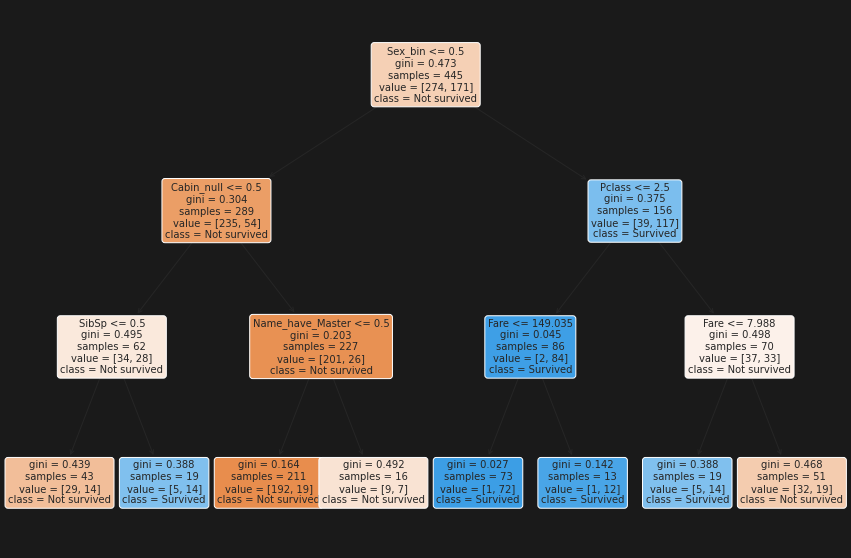

In [39]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor='k')
tree.plot_tree(modelo_arvore,
               ax=ax,
               fontsize=10,
               rounded=True,
               filled=True,
               feature_names=train_X.columns,
               class_names=['Not survived', 'Survived'])

plt.show()

**Variação como forma de otimização do parâmetro max_depth da árvore para tentar encontrar resultados melhores**

Variação do max_depth dentro de um intervalo de valores: entre 1 e 30 camadas.

In [40]:
train=[]
valid=[]
for i in range(1,30):
    modelo_arvore = DecisionTreeClassifier(max_depth = i, random_state=376)
    modelo_arvore.fit(train_X, train_y)
    train.append(modelo_arvore.score(train_X, train_y))
    valid.append(modelo_arvore.score(val_X, val_y))
  
#comparação de acurácia
for i in range(len(train)): 
  print('max_depth:', i+1, 'score treino:', train[i], 'score validação:', valid[i])

max_depth: 1 score treino: 0.7910112359550562 score validação: 0.7825112107623319
max_depth: 2 score treino: 0.8 score validação: 0.773542600896861
max_depth: 3 score treino: 0.8404494382022472 score validação: 0.7780269058295964
max_depth: 4 score treino: 0.8561797752808988 score validação: 0.7959641255605381
max_depth: 5 score treino: 0.8741573033707866 score validação: 0.7937219730941704
max_depth: 6 score treino: 0.8921348314606742 score validação: 0.7847533632286996
max_depth: 7 score treino: 0.9101123595505618 score validação: 0.7959641255605381
max_depth: 8 score treino: 0.9258426966292135 score validação: 0.7825112107623319
max_depth: 9 score treino: 0.9415730337078652 score validação: 0.7780269058295964
max_depth: 10 score treino: 0.9550561797752809 score validação: 0.7914798206278026
max_depth: 11 score treino: 0.9617977528089887 score validação: 0.7959641255605381
max_depth: 12 score treino: 0.9730337078651685 score validação: 0.7982062780269058
max_depth: 13 score treino: 0

**Problema de overfitting:**

Observando as diferenças entre os scores de treino e teste, percebe-se que inicialmente os valores de treino e teste são muito próximos, mas conforme a profundiade da árvore aumenta, os valores de acurácia para os dados de treino aumentam muito, enquanto esses mesmos valores para os dados de teste, caem (a diferença entre eles aumenta).

A medida em que o número de camadas aumenta, o modelo consegue capturar muito bem as características dos dados de treino, em particular.

Em contrapartida, o modelo não consegue generalizar de forma satisfatória as características dos dados de validação, então a acurácia vai caindo em relação ao conjunto de treino ou se mantém estável.

**Conforme o gráfico, o parâmetro ideal seria max_depth = 14.**

[Text(0, 0.5, 'Score'), Text(0.5, 0, 'max_depth')]

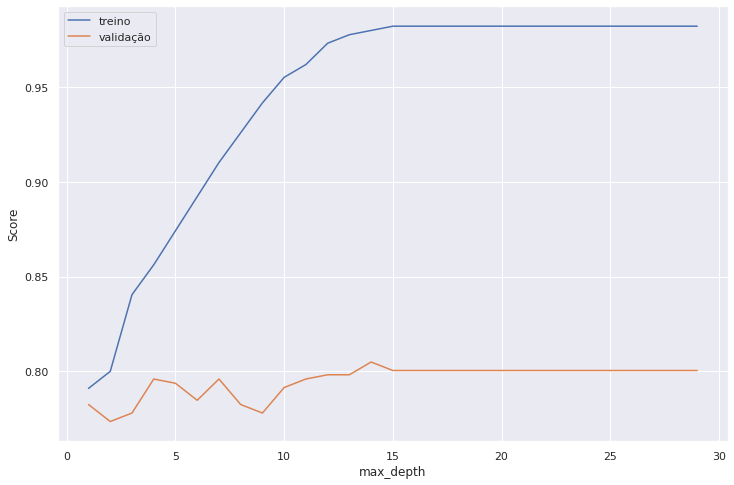

In [41]:
plt.figure(figsize=(12, 8))
ax=sns.lineplot(x=range(1,30), y = train, label='treino')
ax=sns.lineplot(x=range(1,30), y = valid, label='validação')
ax.set(xlabel='max_depth', ylabel='Score')

Modelo de árvore de decisão DecisionTreeClassifier com max_depth = 8.

> **Como acurácia, o modelo de árvore de decisão atingiu 0,805 (~81% das previsões corretas).**

In [42]:
modelo_arvore = DecisionTreeClassifier(max_depth = 14, random_state=376)
modelo_arvore.fit(train_X, train_y)
modelo_arvore.score(val_X, val_y)

0.804932735426009

# **Random Forest algorithm**

Random Forest gera várias árvores de decisão através de amostras aleatórias do conjunto de dados para, posteriormente, realizar as predições.

Random Forest com n_estimators=100.

> **Como acurácia, o modelo de árvore de decisão atingiu 0,814 (~81% das previsões corretas).**

In [43]:
#rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=376)
rf_model = RandomForestClassifier(n_estimators=100, random_state=376)
rf_model.fit(train_X, train_y)
rf_model.score(val_X, val_y)

0.8139013452914798

# **XGBoost algorithm**

XGBoost foi idealizado para otimizar algoritmos de árvore de larga-escala.

XGBoost com:
* max_depth = 4: How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

* gamma = 0.9: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

* eta: step size shrinkage used in each boosting step to prevent overfitting.

> **Como acurácia, o modelo de árvore de decisão atingiu 0,836 (~84% das previsões corretas).**

In [44]:
xgb_model = xgb.XGBClassifier(
 #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1,
 random_state=376).fit(train_X, train_y)

xgb_model.score(val_X, val_y)

0.8363228699551569

# **Cross Validation: *Kfold***

In [45]:
list_acc=[]

kf=RepeatedKFold(n_splits=2, n_repeats=10, random_state=376)

for l_train, l_val in kf.split(X):
  #print(l_train.shape[0], l_val.shape[0])
  train_X, val_X = X.iloc[l_train], X.iloc[l_val]
  train_y, val_y = y.iloc[l_train], y.iloc[l_val]

  ##train
  #ml_model = LogisticRegression(max_iter=1000, random_state=376)

  ml_model = xgb.XGBClassifier(
  #learning_rate = 0.02,
  n_estimators= 2000,
  max_depth= 4,
  min_child_weight= 2,
  #gamma=1,
  gamma=0.9,                        
  subsample=0.8,
  colsample_bytree=0.8,
  objective= 'binary:logistic',
  nthread= -1,
  scale_pos_weight=1,
  random_state=376)

  ml_model.fit(train_X, train_y)

  ##test and score
  rf_val_predictions = ml_model.predict(val_X)
  acc=ml_model.score(val_X, val_y)
  list_acc.append(acc)

#print(np.mean(list_acc), np.min(list_acc), np.max(list_acc))

**Plotting results of the Kfold validation step using the XGBoost model**

> Distribution of the obtained scores for 10 runs of train and test.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([3., 0., 1., 1., 5., 1., 3., 1., 2., 3.]),
 array([0.78426966, 0.78925077, 0.79423187, 0.79921298, 0.80419408,
        0.80917519, 0.8141563 , 0.8191374 , 0.82411851, 0.82909961,
        0.83408072]),
 <a list of 10 Patch objects>)

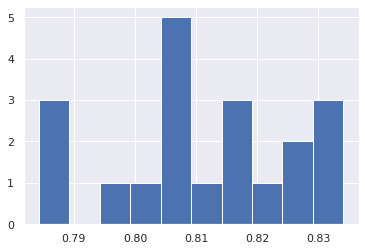

In [46]:
%matplotlib inline
%pylab inline
pylab.hist(list_acc)

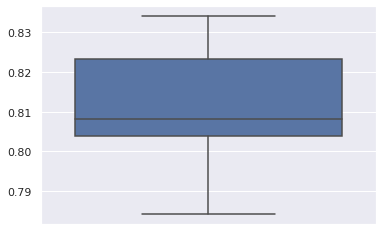

In [47]:
sns.boxplot(y=list_acc)

# **Error analysis of features**

Comparing the predicted results with the expected output in respect of the other features.

In [48]:
val_X_check = train_data.iloc[l_val].copy()
val_X_check['Prediction'] = rf_val_predictions
#val_X_check.head()

X_errors=val_X_check[val_X_check['Survived']!=val_X_check['Prediction']] #show only the errors between prediciton and expected output
X_errors=X_errors[features+['Prediction', 'Survived']]
display(X_errors.head())

X_women=X_errors[X_errors['Sex_bin']==1]
X_men=X_errors[X_errors['Sex_bin']==0]
#print(X_women.sort_values('Survived'))
print(X_men.sort_values('Survived'))


,Pclass,Age,SibSp,Parch,Fare,Sex_bin,Embarked_num,Cabin_null,Name_have_Miss,Name_have_Mrs,Name_have_Mr,Name_have_Master,Name_have_Dr,Name_have_Rev,Prediction,Survived
2,3,26.0,0,0,7.9250,1,0.0,1,1,0,0,0,0,0,0,1
25,3,38.0,1,5,31.3875,1,0.0,1,0,1,0,0,0,0,0,1
35,1,42.0,1,0,52.0000,0,0.0,1,0,0,1,0,0,0,1,0
60,3,22.0,0,0,7.2292,0,1.0,1,0,0,1,0,0,0,1,0
62,1,45.0,1,0,83.4750,0,0.0,0,0,0,1,0,0,0,1,0


     Pclass   Age  SibSp  Parch      Fare  Sex_bin  Embarked_num  Cabin_null  \
35        1  42.0      1      0   52.0000        0           0.0           1   
339       1  45.0      0      0   35.5000        0           0.0           0   
372       3  19.0      0      0    8.0500        0           0.0           1   
422       3  29.0      0      0    7.8750        0           0.0           1   
462       1  47.0      0      0   38.5000        0           0.0           0   
475       1   NaN      0      0   52.0000        0           0.0           0   
536       1  45.0      0      0   26.5500        0           0.0           0   
332       1  38.0      0      1  153.4625        0           0.0           0   
583       1  36.0      0      0   40.1250        0           1.0           0   
693       3  25.0      0      0    7.2250        0           1.0           1   
713       3  29.0      0      0    9.4833        0           0.0           1   
741       1  36.0      1      0   78.850

# **Test step**

Including the entire train and test sets with XGBoost algorithm.

In [49]:
##training
ml_model = xgb.XGBClassifier(
 #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1,
 random_state=376)

ml_model.fit(X, y)
xgb_val_predictions = ml_model.predict(X_test)


# **Test step with ensemble**

Modelo de ensemble consiste em um algoritmo que reúne diferentes modelos de ML para prever algum resultado, usando algoritmos de modelagem diferentes ou diferentes conjuntos de dados de treinamento. 

O ensemble agrega a previsão de cada modelo, gerando uma previsão final. A motivação para usar modelos de ensemble de ML é reduzir o erro de generalização da previsão. Desde que os modelos de base sejam diversos e independentes, o erro de predição do modelo diminui quando o modelo de ennsemble é empregado. 

A abordagem busca o consenso das massas ao fazer uma previsão. Mesmo que o ensemble englobe vários algoritmos de ML, este atuará como um único modelo. A maioria das soluções práticas de ML utiliza técnicas de ensemble.

**Ensemble ML model with Logistic Regression (w=0.3), Random Forest (w=0.3) and XGBoost (w=0.4).**

In [50]:
#ml_model = DecisionTreeClassifier(max_depth = 3, random_state=376)

ml_model = RandomForestClassifier(n_estimators=100, random_state=376)
ml_model.fit(X, y)
rf_predictions = ml_model.predict(X_test)

ml_model = LogisticRegression(max_iter=1000, random_state=376)
ml_model.fit(X, y)
lr_predictions = ml_model.predict(X_test)

ml_model = xgb.XGBClassifier(
 #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1,
 random_state=376)

ml_model.fit(X, y)
xgb_predictions = ml_model.predict(X_test)

ml_val_predictions=0.3*rf_predictions+0.3*lr_predictions+0.4*xgb_predictions
ml_val_predictions=[(lambda x:1 if x>=0.5 else 0)(x) for x in ml_val_predictions]

**Save predictions in format used for Titanic competition scoring**

In [51]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': ml_val_predictions})

#output = pd.Series(rf_val_predictions, index=test_data['PassengerId'], name='Survived')

output.to_csv('submission.csv', header=True, index=False)
!head -n10 submission.csv
#files.download('submission.csv')

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1
